## Loading labels

In [2]:
import pandas as pd

In [4]:
labels = pd.read_csv('data/inBreast/INbreast_Release_1.0/labels.csv')

In [5]:
labels.head()

,Patient ID,Laterality,View,File Name,Mass,Micros,File ID,DICOM Path,Benign Calcification,Benign Mass,Malignant Calcification,Malignant Mass,Normal,PNG Path,Pect Rem
0,61b13c59bcba149e,R,CC,22678622.0,NaN,NaN,22678622,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...,0,0,0,0,1,data/inBreast/INbreast_Release_1.0/AllPNGs/226...,NaN
1,61b13c59bcba149e,L,CC,22678646.0,X,NaN,22678646,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...,0,1,0,0,0,data/inBreast/INbreast_Release_1.0/AllPNGs/226...,NaN
2,61b13c59bcba149e,R,MLO,22678670.0,NaN,NaN,22678670,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...,0,0,0,0,1,data/inBreast/INbreast_Release_1.0/AllPNGs/226...,data/inBreast/INbreast_Release_1.0/PectRem/226...
3,61b13c59bcba149e,L,MLO,22678694.0,X,NaN,22678694,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...,0,1,0,0,0,data/inBreast/INbreast_Release_1.0/AllPNGs/226...,data/inBreast/INbreast_Release_1.0/PectRem/226...
4,6bd24a0a42c19ce1,R,CC,22614074.0,X,X,22614074,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...,0,0,1,1,0,data/inBreast/INbreast_Release_1.0/AllPNGs/226...,NaN


## Mask Extraction

In [1]:
import xml.etree.ElementTree as ET
import glob
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, box

In [6]:
def parse_xml(path):
    dct = {}
    ind = 0
    tree = ET.parse(path)
    root = tree.getroot()
    array = root[0][1][0][-1]
    
    for entry in array:
        dct[ind] = [None, None]
        name = 0
        pt = 0

        for child in entry:
            if name:
                dct[ind][0] = child.text
                name = 0
            if child.text == 'Name':
                name = 1
            if pt:
                dct[ind][1] = []

                for stri in child:
                    t = stri.text
                    tup = (float(t[1:t.find(',')]), float(t[t.find(',')+2:-1]))
                    dct[ind][1].append(tup)
                pt = 0
            if child.text == 'Point_px':
                pt = 1
        ind += 1
        
    return dct

In [7]:
xml_dir_path = 'data/inBreast/INbreast_Release_1.0/AllXML/'
rois_pathes = glob.glob(str(xml_dir_path + '*.xml'))

In [8]:
rois = pd.DataFrame()
ids = []
for p in rois_pathes:
    ids.append(p[p.rfind('/')+1:-4])
rois['ID'] = ids

In [9]:
regs = []
for p in rois_pathes:
    regs.append(parse_xml(p))
rois['pts'] = regs

In [10]:
rois

,ID,pts
0,50997651,"{0: ['Calcification', [(1457.380005, 1854.5899..."
1,50999459,"{0: ['Mass', [(967.768982, 1645.619995), (959...."
2,53580638,"{0: ['Calcification', [(2731.810059, 3544.9699..."
3,24065434,"{0: ['Calcification', [(1038.650024, 3287.0300..."
4,51049462,"{0: ['Calcification', [(1311.119995, 2360.8798..."
...,...,...
338,50996228,"{0: ['Calcification', [(162.764008, 2747.28002..."
339,22427705,"{0: ['Calcification', [(306.131958, 1878.98742..."
340,24065734,"{0: ['Calcification', [(1020.109985, 2109.6201..."
341,53587131,"{0: ['Calcification', [(805.182007, 2901.18994..."


## Image rotation

In [13]:
from skimage import io
from skimage import color
import cv2 as cv

In [11]:
def read_image(filename):
    image = io.imread(filename)
    image = color.rgb2gray(image)
    image = right_orient_mammogram(image)
    return image

In [12]:
def right_orient_mammogram(image):
#     print('in right_orient')
    left_nonzero = cv.countNonZero(image[:, 0:int(image.shape[1]/2)])
    right_nonzero = cv.countNonZero(image[:, int(image.shape[1]/2):])
    
    if(left_nonzero < right_nonzero):
#         print('flip')
        image = cv.flip(image, 1)

    return image

## Patch extraction

In [37]:
import numpy as np
from tqdm import tqdm
import matplotlib

In [14]:
def sliding_window(image, stepSize, windowSize):
    windows = []
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            windows.append((x, y, image[y:y + windowSize[1], x:x + windowSize[0]]))
    return windows

In [15]:
def filter_patches(patches):
    filtered = []
    threshold = 0.02
    
    x = 256
    y = 256
    
    for p in patches:
        if (1 - (np.count_nonzero(p[2])/(x*y)) < threshold):
            filtered.append(p)
            
    return filtered

In [118]:
def filter_mass_patches(patches, mass_polys):
    treshold = 0.25
    filtered = {'mass': [], 'norm': []}
    for mass in mass_polys:
        for p in patches:
            patch_poly = box(p[0], p[1], p[0] + 255, p[1] + 255)
            intersection = patch_poly.intersection(mass).area
            if intersection > 0 and 0.9 >= intersection/(256*256) >=  treshold:
                if p not in filtered['mass']:
                    filtered['mass'].append(p)                
            elif intersection == 0:
                if p not in filtered['norm']:
                    filtered['norm'].append(p)
    return filtered

In [119]:
def filter_calc_patches(patches, calc_polys):
    calc_polys = [_ for _ in calc_polys if _]
    if not len(calc_polys):
        return {'calc': [], 'norm': []}
    filtered = {'calc': [], 'norm': []}
    for calc in calc_polys:
        for p in patches:
            patch_poly = box(p[0] + 25, p[1] + 25, p[0] + 220, p[1] + 220)
            if patch_poly.contains(calc):
                if p in filtered['norm']:
                    filtered['norm'].remove(p)
                if p not in filtered['calc']:
                    filtered['calc'].append(p)
            elif patch_poly.intersects(calc):
                if p in filtered['norm']:
                    filtered['norm'].remove(p)
                continue
            else:
                 if p not in filtered['norm']:
                    filtered['norm'].append(p)
    return filtered

In [38]:
def extract_healthy(row):
    patches_dir = 'data/inBreast/INbreast_Release_1.0/PatchesByClass/1/'

    if row['View'] == 'CC':
        png_path = row['PNG Path']
    elif row['Pect Rem']:
        png_path = row['Pect Rem']
    else:
        print(row['PNG Path'])
        return   

    patches_dir += str(row['File ID'])[:-4]

    count = 0 
    names = []

    image = read_image(png_path)
    patches = sliding_window(image, 128, (256, 256))

    filtered_patches = filter_patches(patches)

    x_start = [p[0] for p in filtered_patches]
    y_start = [p[1] for p in filtered_patches]
    arr = [p[2] for p in filtered_patches]   


    for im in arr:
        name = patches_dir + '-' + str(count) + '.png'
        names.append(name)
        count += 1
        matplotlib.image.imsave(name, im, cmap='gray')
    
    return names

In [126]:
def extract_abn(row, rois):
    patches_dir = 'data/inBreast/INbreast_Release_1.0/PatchesByClass/'

    if row['View'] == 'CC':
        png_path = row['PNG Path']
    elif row['Pect Rem']:
        png_path = row['Pect Rem']
    else:
        print(row['PNG Path'])
        return
    
    image = read_image(png_path)

    patches = sliding_window(image, 128, (256, 256))

    file_ID = row['File ID']                
            
    abn_mass = [Polygon(pts[1]) for pts in rois.loc[rois['ID'] == str(file_ID)]['pts'].tolist()[0].values() if pts[0] == 'Mass']
    abn_calc = [Polygon(pts[1]) if (pts[0] == 'Calcification' and len(pts[1]) > 1) 
                else Point(pts[1]) if (pts[0] == 'Calcification' and len(pts[1]) == 1) else None 
                for pts in rois.loc[rois['ID'] == str(file_ID)]['pts'].tolist()[0].values()]

    mass_patches = []
    for mass in abn_mass:
        if not mass:
            break

        x = int(mass.centroid.coords[0][0])
        y = int(mass.centroid.coords[0][1])

        if x > 256:
            x -= 256
        else:
            x = 0
        if y > 256:
            y -= 256
        else:
            y = 0
        wsize = 256

        mass_patches.append((x, y, image[y:y + wsize, x:x + wsize]))
        mass_patches.append((x+256, y, image[y:y + wsize, x:x + wsize]))
        mass_patches.append((x, y+256, image[y:y + wsize, x:x + wsize]))
        mass_patches.append((x+256, y+256, image[y:y + wsize, x:x + wsize]))
        mass_patches.append((x+128, y+128, image[y:y + wsize, x:x + wsize]))

    calc_patches = []
    for calc in abn_calc:
        if not calc:
            break            
        x = int(calc.centroid.coords[0][0])
        y = int(calc.centroid.coords[0][1])

        if x > 128:
            x -= 128
        else:
            x = 0
        if y > 128:
            y -= 128
        else:
            y = 0

        wsize = 256
        calc_patches.append((x, y, image[y:y + wsize, x:x + wsize]))

    patches = filter_patches(patches)
    mass_patches = filter_patches(mass_patches)
    calc_patches = filter_patches(calc_patches)


    filtered_mass_patches = filter_mass_patches(patches, abn_mass)
    filtered_mass_patches['mass'].extend(filter_mass_patches(mass_patches, abn_mass)['mass'])

    filtered_calc_patches = filter_calc_patches(patches, abn_calc)
    filtered_calc_patches['calc'].extend(calc_patches)

    filtered_patches = {'mass': filtered_mass_patches['mass'], 'calc': filtered_calc_patches['calc'], 
                        'norm': filtered_mass_patches['norm']}

    for p in filtered_calc_patches['norm']:
        if p not in filtered_patches['norm']:
            filtered_patches['norm'].append(p)

    for p in filtered_patches['mass']:
        if p in filtered_patches['calc']:
            filtered_patches['mass'].remove(p)
            filtered_patches['calc'].remove(p)
            
    names = []

    if len(filtered_patches['mass']) > 0:
        if row['Benign Mass'] == 1:
            path = patches_dir + '2/' + str(row['File ID'])
        else:
            path = patches_dir + '4/' + str(row['File ID'])
        count = 0 
        for p in filtered_patches['mass']:
            name = path + '-' + str(count) + '.png'
            names.append(name)
            count += 1
            matplotlib.image.imsave(name, p[2], cmap='gray')

    if len(filtered_patches['calc']) > 0:
        if row['Benign Calcification'] == 1:
            path = patches_dir + '3/' + str(row['File ID'])
        else:
            path = patches_dir + '5/' + str(row['File ID'])
        count = 0 
        for p in filtered_patches['calc']:
            name = path + '-' + str(count) + '.png'
            names.append(name)
            count += 1
            matplotlib.image.imsave(name, p[2], cmap='gray')

    return names

In [39]:
healthy = labels.loc[labels['Normal'] == 1]
ind = healthy.index.tolist()

healthy_names = []
for i in tqdm(ind):
    healthy_names = extract_healthy(labels.iloc[i])

  0%|          | 0/65 [00:00<?, ?it/s]<ipython-input-11-36f484922f9f>:3: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  image = color.rgb2gray(image)
100%|██████████| 65/65 [04:25<00:00,  4.08s/it]


In [125]:
abnormal = labels.loc[labels['Normal'] != 1]
ind = abnormal.index.tolist()

abnormal_names = []
for i in tqdm(ind[314:]):
    abnormal_names.append(extract_abn(labels.iloc[i], rois))

  0%|          | 0/21 [00:00<?, ?it/s]<ipython-input-11-36f484922f9f>:3: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  image = color.rgb2gray(image)
100%|██████████| 21/21 [00:29<00:00,  1.41s/it]


In [ ]:
283, 313

## Visualization

In [14]:
import os
import random
import matplotlib.pyplot as plt
import cv2

In [9]:
dir = 'data/inBreast/INbreast_Release_1.0/PatchesByClass/'
cl = 1

In [10]:
fname = random.choice(os.listdir(str(dir + str(cl))))
print(fname)

2267-61.png


In [13]:
for i in range(1, 5):
    print(i)

1
2
3
4


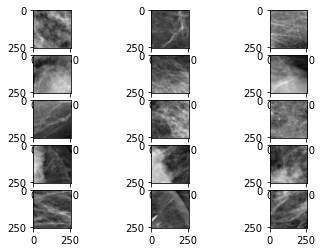

<Figure size 360x1080 with 0 Axes>

In [20]:
fig, axs = plt.subplots(5, 3)
plt.figure(figsize = (5, 15))
for cl in range(1, 6):
    for i in range(3):
        path = str(dir + str(cl))
        fname = random.choice(os.listdir(path))
        path += '/' + fname
        img = cv2.imread(path)
        axs[cl-1, i].imshow(img)